In [ ]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
import pickle
from collections import Counter
import time
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
source = r'/home/ronit/Downloads/Facebook'

In [ ]:
train_data = pd.read_csv(source+'/train.csv')

In [ ]:
print(train_data.head())

   source_node  destination_node
0            1            690569
1            1            315892
2            1            189226
3            2            834328
4            2           1615927


In [ ]:
def check_nan(dataset):
    is_NaN = dataset.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    return list(dataset[row_has_NaN][['source_node','destination_node']]),list(dataset[row_has_NaN].index.values)

In [ ]:
print('Any na values',check_nan(train_data))
print(train_data.info())
print("Number of diplicate entries: ",sum(train_data.duplicated()))
train_data.to_csv(source+'/train_data_no_header.csv',header=False,index=False)
g = nx.read_edgelist(source+'/train_data_no_header.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Any na values (['source_node', 'destination_node'], [])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB
None
Number of diplicate entries:  0
Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


In [ ]:
print('Number of unique nodes',len(g.nodes()))

Number of unique nodes 1862220


No of followers

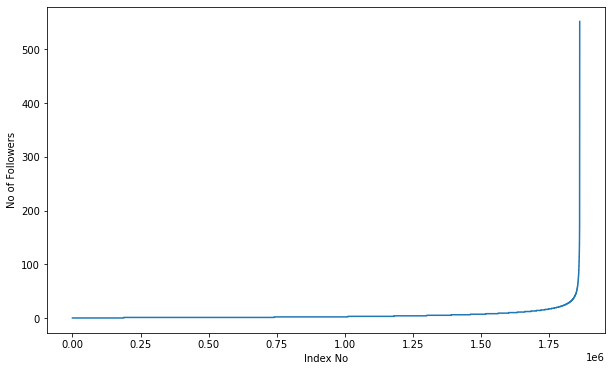

In [ ]:
indegree_value = list(dict(g.in_degree()).values())
indegree_value.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_value)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

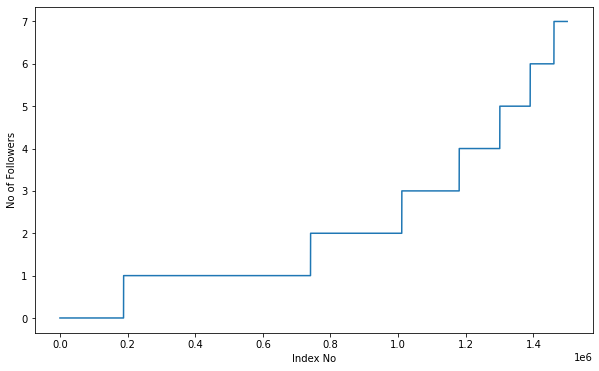

In [ ]:
indegree_value = list(dict(g.in_degree()).values())
indegree_value.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_value[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

As we can see in the above graph around 200000 have zero followers and 1400000 have 7 or less than 7 followers.

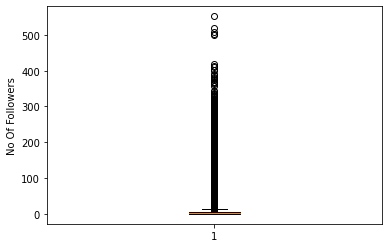

In [ ]:
plt.boxplot(indegree_value)
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
for i in range(0,11):
  print(90+i, 'percentile value is ', np.percentile(indegree_value,90+i))

90 percentile value is  12.0
91 percentile value is  13.0
92 percentile value is  14.0
93 percentile value is  15.0
94 percentile value is  17.0
95 percentile value is  19.0
96 percentile value is  21.0
97 percentile value is  24.0
98 percentile value is  29.0
99 percentile value is  40.0
100 percentile value is  552.0


99% of data having followers of 40 only.

In [ ]:
for i in range(10,110,10):
  print(99+(i/100), 'percentile value is ', np.percentile(indegree_value,99+(i/100)))

99.1 percentile value is  42.0
99.2 percentile value is  44.0
99.3 percentile value is  47.0
99.4 percentile value is  50.0
99.5 percentile value is  55.0
99.6 percentile value is  61.0
99.7 percentile value is  70.0
99.8 percentile value is  84.0
99.9 percentile value is  112.0
100.0 percentile value is  552.0


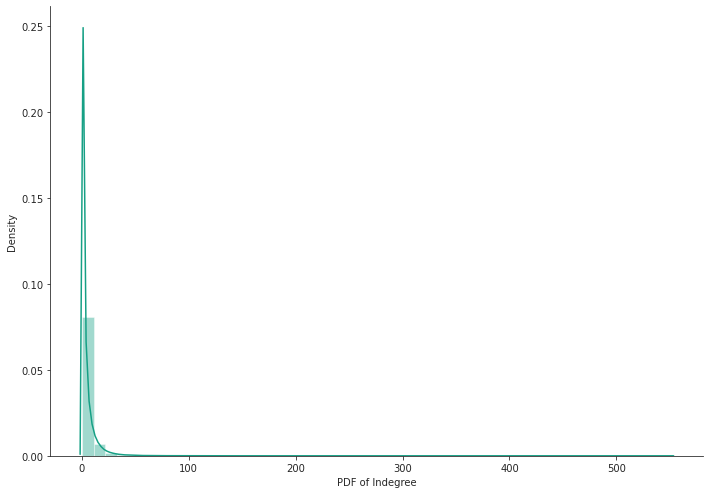

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_value, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

No of people each person is following

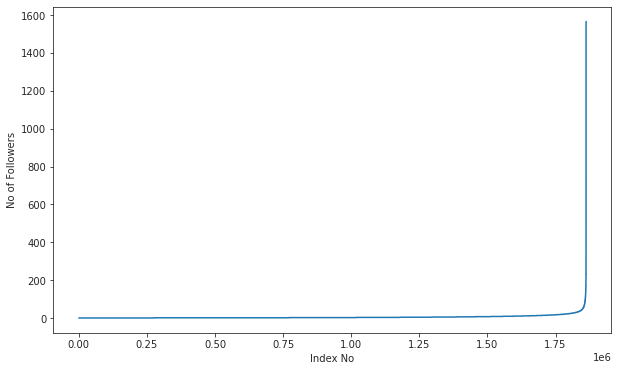

In [ ]:
outdegree_value = list(dict(g.out_degree()).values())
outdegree_value.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_value)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

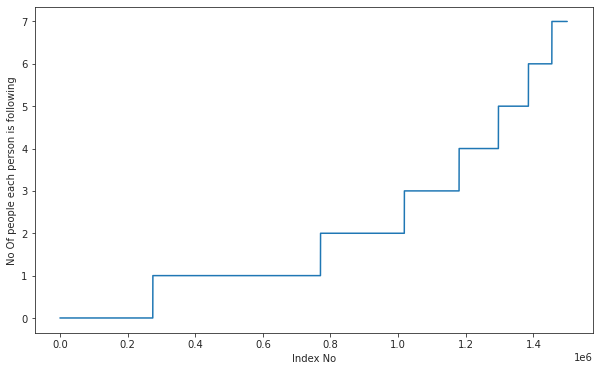

In [ ]:
outdegree_value = list(dict(g.out_degree()).values())
outdegree_value.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_value[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

More 200000 people are not following any one.

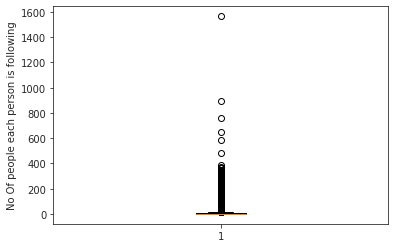

In [ ]:
plt.boxplot(outdegree_value)
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_value,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_value,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


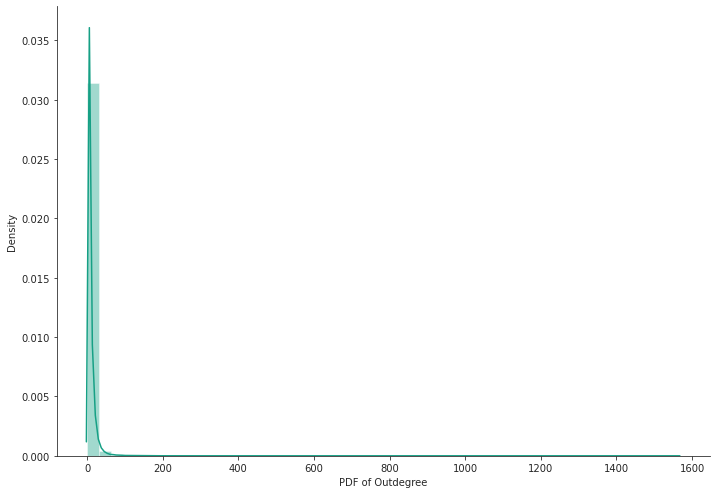

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_value, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_value)==0),'and % is',sum(np.array(outdegree_value)==0)*100/len(outdegree_value))

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [ ]:
print('No of person having zero followers', sum(np.array(indegree_value)==0), 'and % is ', (sum(np.array(indegree_value)==0)*100)/len(indegree_value))

No of person having zero followers 188043 and % is  10.097786512871734


In [ ]:
count = 0
for node in g.nodes():
  if len(list(g.predecessors(node)))==0 and len(list(g.successors(node)))==0:
    count = count + 1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


both followers + following

In [ ]:
in_degree = dict(g.in_degree)
out_degree = dict(g.out_degree)
in_out_degree = Counter(in_degree)+Counter(out_degree)
in_out_degree_value = np.array(list(in_out_degree.values()))

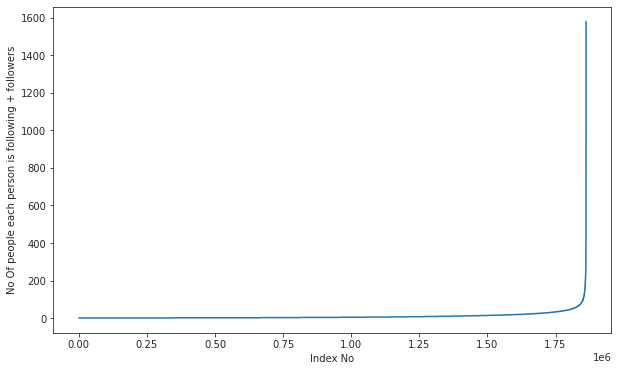

In [ ]:
in_out_degree_sort = sorted(in_out_degree_value)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

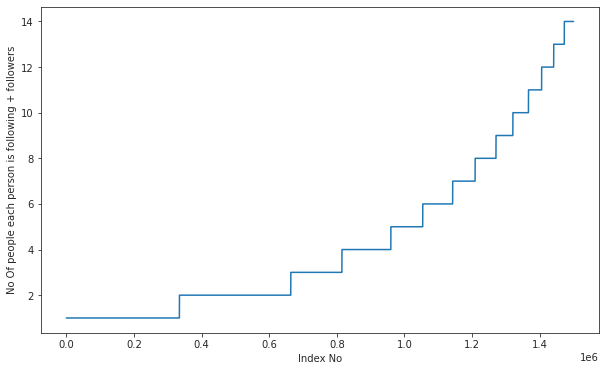

In [ ]:
in_out_degree_sort = sorted(in_out_degree_value)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [ ]:
print('Min no of follower + following is', in_out_degree_value.min())
print('No of user having min no of follower+following',sum(np.array(in_out_degree_value)==in_out_degree_value.min()))

Min no of follower + following is 1
No of user having min no of follower+following 334291


In [ ]:
print('Max no of follower + following is', in_out_degree_value.max())
print('No of user having max no of follower+following',sum(np.array(in_out_degree_value)==in_out_degree_value.max()))

Max no of follower + following is 1579
No of user having max no of follower+following 1


In [ ]:
print('No of users having followers + following less than 10 are',np.sum(in_out_degree_value<10))

No of users having followers + following less than 10 are 1320326


In [ ]:
start_time = time.time()
weakly_connected_components = list(nx.weakly_connected_components(g))
print('No of weekly connected component',len(weakly_connected_components))
count = 0
for i in weakly_connected_components:
  if len(i)==2:
    count = count +1
print('weakly connected components wit 2 nodes',count)
print(time.time() - start_time)

No of weekly connected component 45558
weakly connected components wit 2 nodes 32195
23.157983779907227


The below code is randomly generating the negative  group which donot have a link

In [ ]:
start_time = time.time()
if not os.path.isfile(source+'/missing_edges_final.p'):
  r = csv.reader(open(source+'/train_data_no_header.csv','r'))
  edges = dict()
  for edge in r:
    edges[(edge[0],edge[1])] = 1
  missing_edges = set([])
  while len(missing_edges)<9437519:
    node_1 = random.randint(1,1862220)
    node_2 = random.randint(1,1862220)
    check_edges = edges.get((node_1,node_2),-1)
    if check_edges == -1 and node_1!=node_2:
      try:
        if nx.shortest_path_length(g,source=node_1,target=node_2) > 2:
          missing_edges.add((node_1,node_2))
          #break
        else:
          continue
      except:
        missing_edges.add((node_1,node_2))
    else:
      continue
    if len(missing_edges)%100000==0:
      print('Completed',len(missing_edges))
  pickle.dump(missing_edges,open(source+'/missing_edges_final.p','wb'))
else:
  missing_edges = pickle.load(open(source+'/missing_edges_final.p','rb'))
print(time.time() - start_time)

3.0486207008361816


In [ ]:
print(len(missing_edges))

9437519


In [ ]:
df_pos = pd.read_csv(source+'/train.csv')
df_neg = pd.DataFrame(list(missing_edges),columns=['source_node', 'destination_node'])
print('Shape of positive',df_pos.shape)
print('Shape of negative',df_neg.shape)
print('*'*50)
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
print('Number of nodes in the train data graph with edges',X_train_pos.shape[0],y_train_pos.shape[0])
print('Number of nodes in the train data graph without edges',X_train_neg.shape[0],y_train_neg.shape[0])
print('*'*50)
print('Number of nodes in the test data graph with edges',X_test_pos.shape[0],y_test_pos.shape[0])
print('Number of nodes in the test data graph without edges',X_test_neg.shape[0],y_test_neg.shape[0])  

Shape of positive (9437519, 2)
Shape of negative (9437519, 2)
**************************************************
Number of nodes in the train data graph with edges 7550015 7550015
Number of nodes in the train data graph without edges 7550015 7550015
**************************************************
Number of nodes in the test data graph with edges 1887504 1887504
Number of nodes in the test data graph without edges 1887504 1887504


In [ ]:
if (not os.path.isfile(source+'/train_pos_after_eda.csv')) and (not os.path.isfile(source+'/test_pos_after_eda.csv')):

  df_pos = pd.read_csv(source+'/train.csv')
  df_neg = pd.DataFrame(list(missing_edges),columns=['source_node', 'destination_node'])
  print('Shape of positive',df_pos.shape)
  print('Shape of negative',df_neg.shape)
  print('*'*50)
  X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
  X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
  print('Number of nodes in the train data graph with edges',X_train_pos.shape[0],y_train_pos.shape[0])
  print('Number of nodes in the train data graph without edges',X_train_neg.shape[0],y_train_neg.shape[0])
  print('*'*50)
  print('Number of nodes in the test data graph with edges',X_test_pos.shape[0],y_test_pos.shape[0])
  print('Number of nodes in the test data graph without edges',X_test_neg.shape[0],y_test_neg.shape[0])

  X_train_pos.to_csv(source+'/train_pos_after_eda.csv',header=False, index=False)
  X_test_pos.to_csv(source+'/test_pos_after_eda.csv',header=False, index=False)
  X_train_neg.to_csv(source+'/train_neg_after_eda.csv',header=False, index=False)
  X_test_neg.to_csv(source+'/test_neg_after_eda.csv',header=False, index=False)



In [ ]:
if (os.path.isfile(source+'/train_pos_after_eda.csv')) and (os.path.isfile(source+'/test_pos_after_eda.csv')):
  train_graph = nx.read_edgelist(source+'/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  test_graph = nx.read_edgelist(source+'/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(train_graph))
  print('*'*50)
  print(nx.info(test_graph))
  print('*'*50)

  train_nodes_pos = set(train_graph.nodes())
  test_nodes_pos = set(test_graph.nodes())

  print('no of people common in train and test:',len(train_nodes_pos.intersection(test_nodes_pos)))
  print('no of people present in train but not present in test:',len(train_nodes_pos-test_nodes_pos))

  print('no of people present in test but not present in train:',len(test_nodes_pos-train_nodes_pos))



Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
**************************************************
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
**************************************************
no of people common in train and test: 1063125
no of people present in train but not present in test: 717597
no of people present in test but not present in train: 81498


In [ ]:
X_train_pos = pd.read_csv(source+'/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv(source+'/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv(source+'/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv(source+'/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('*'*50)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

X_train.to_csv(source+'/train_after_eda.csv',header=False,index=False)
X_test.to_csv(source+'/test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv(source+'/train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv(source+'/test_y.csv',header=False,index=False)

print('*'*50)
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
**************************************************
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504
**************************************************
Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


The original graph on which all the featurization will be done for all the nodes.

In [ ]:
if os.path.isfile(source+'/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist(source+'/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [ ]:
#for followees
def jaccard_for_followees(node_1,node_2):
  try:
    node_1_set = set(train_graph.successors(node_1)) 
    node_2_set = set(train_graph.successors(node_2))
    if len(node_1_set)==0 | len(node_2_set)==0:
      return 0
    else:
      sim = len(node_1_set.intersection(node_2_set))/len(node_1_set.union(node_2_set))
  except:
    return 0
  return sim

In [ ]:
def jaccard_for_followers(node_1,node_2):
  try:
    node_1_set = set(train_graph.predecessors(node_1)) 
    node_2_set = set(train_graph.predecessors(node_2))
    if len(node_1_set)==0 | len(node_2_set)==0:
      return 0
    else:
      sim = len(node_1_set.intersection(node_2_set))/len(node_1_set.union(node_2_set))
  except:
    return 0
  return sim

In [ ]:
def cosine_for_followees(node_1,node_2):
  try:
    node_1_set = set(train_graph.successors(node_1)) 
    node_2_set = set(train_graph.successors(node_2))
    if len(node_1_set)==0 | len(node_2_set)==0:
      return 0
    else:
      sim = len(node_1_set.intersection(node_2_set))/(math.sqrt(len(node_1_set)*len(node_2_set)))
  except:
    return 0
  return sim

In [ ]:
def cosine_for_followers(node_1,node_2):
  try:
    node_1_set = set(train_graph.predecessors(node_1)) 
    node_2_set = set(train_graph.predecessors(node_2))
    if len(node_1_set)==0 | len(node_2_set)==0:
      return 0
    else:
      sim = len(node_1_set.intersection(node_2_set))/(math.sqrt(len(node_1_set)*len(node_2_set)))
      #print(len(node_1_set.intersection(node_2_set)),len(node_1_set),len(node_2_set))
  except:
    return 0
  return sim

In [ ]:
if not os.path.isfile(source+'/page_rank.p'):
  page_rank = nx.pagerank(train_graph,alpha=0.85)
  pickle.dump(page_rank,open(source+'/page_rank','wb'))
else:
  page_rank = pickle.load(open(source+'/page_rank','r'))

In [ ]:
print('min',page_rank[min(page_rank, key=page_rank.get)])
print('max',page_rank[max(page_rank, key=page_rank.get)])
mean_pr = float(sum(page_rank.values())) / len(page_rank)
print('mean',mean_pr)

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [ ]:
def compute_shortest_path_length(node_1,node_2):
  p = -1
  try:
    if train_graph.has_edge(node_1,node_2):
      train_graph.remove_edge(node_1,node_2)
      p = nx.shortest_path_length(train_graph,node_1,node_2)
      train_graph.add_edge(node_1,node_2)
    else:
      p = nx.shortest_path_length(train_graph,node_1,node_2)
    return p
  except:
    return -1

In [ ]:
wcc = list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(node_1,node_2):
  index = []
  if train_graph.has_edge(node_2,node_1):
    return 1
  if train_graph.has_edge(node_1,node_2):
    for i in wcc:
      if node_1 in i:
        index = i
        break
    if node_2 in index:
      train_graph.remove_edge(node_1,node_2)
      if compute_shortest_path_length(node_1,node_2)==-1:
        train_graph.add_edge(node_1,node_2)
        return 0
      else:
        train_graph.add_edge(node_1,node_2)
        return 1
    else:
      return 0
  else:
    for i in wcc:
      if node_1 in i:
        index = i
        break
    if node_2 in index:
      return 1
    else:
      return 0

In [ ]:
def calc_adar_in(node_1,node_2):
  try:
    sum = 0
    nodes = list(set(train_graph.successors(node_1)).intersection(set(train_graph.successors(node_2))))
    if len(n)>0:
      for node in nodes:
        sum = sum + (1/(np.log10(len(list(train_graph.predecessors(node))))))
      return sum
    else:
      return 0
  except:
    return 0

In [ ]:
def follows_back(node_1,node_2):
  if train_graph.has_edge(node_2,node_1):
    return 1
  else:
    return 0

In [ ]:
if not os.path.isfile(source+'/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open(source+'/katz.p','wb'))
    print('New file created')
else:
    katz = pickle.load(open(source+'/katz.p','rb'))
    print('Exicting file loaded')

Exicting file loaded


In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
mean_katz = float(sum(katz.values())) / len(katz)
print('mean',mean_katz)

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [ ]:
if not os.path.isfile(source+'/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open(source+'/hits.p','wb'))
    print('New file created')
else:
    hits = pickle.load(open(source+'/hits.p','rb'))
    print('Exicting file loaded')

Exicting file loaded


In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


In [ ]:
def pf_attachment_for_followers(node_1,node_2):
  try:
    node_1_value = set(train_graph.predecessors(node_1))
    node_2_value = set(train_graph.predecessors(node_2))
    if len(node_1_value)==0 | len(node_2_value)==0:
      return 0
    score = len(node_1_value*node_2_value)
    return score
  except:
    return 0

In [ ]:
def pf_attachment_for_followees(node_1,node_2):
  try:
    node_1_value = set(train_graph.successors(node_1))
    node_2_value = set(train_graph.successors(node_2))
    if len(node_1_value)==0 | len(node_2_value)==0:
      return 0
    score = len(node_1_value*node_2_value)
    return score
  except:
    return 0

In [ ]:
# #delete the step an remove skip from next step
# n_train =  15100030
# s = 10000 #desired sample size
# skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
# n_test = 3775008
# s = 5000 #desired sample size
# skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [ ]:
# print(n_test-len(skip_test))

In [ ]:
df_final_train = pd.read_csv(source+'/train_after_eda.csv',names=['source_node', 'destination_node'])#skiprows=skip_train,
df_final_train['indicator_link'] = pd.read_csv(source+'/train_y.csv',names=['indicator_link'])#skiprows=skip_train,
print(df_final_train.head())
print(df_final_train.shape)

   source_node  destination_node  indicator_link
0       273084           1505602               1
1       912810           1678443               1
2       365429           1523458               1
3       527014           1605979               1
4      1228116            471233               1
(15100030, 3)


In [ ]:
df_final_test = pd.read_csv(source+'/test_after_eda.csv',names=['source_node', 'destination_node'])#skiprows=skip_test,
df_final_test['indicator_link'] = pd.read_csv(source+'/test_y.csv',names=['indicator_link'])# skiprows=skip_test, 
print(df_final_test.head())
print(df_final_test.shape)

   source_node  destination_node  indicator_link
0       848424            784690               1
1      1248963            444518               1
2       264224            132395               1
3       549680            326829               1
4       875380           1394902               1
(3775008, 3)


In [ ]:
if not os.path.isfile(source+'/df_final_train_stage_1.csv'):

  df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
  df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

  df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
  df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)

  df_final_train['cosine_followers'] = df_final_train.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
  df_final_test['cosine_followers'] = df_final_test.apply(lambda row: cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

  df_final_train['cosine_followees'] = df_final_train.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
  df_final_test['cosine_followees'] = df_final_test.apply(lambda row: cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
else:
  print('no')

no


In [ ]:
print(df_final_train.head())
print(df_final_train.shape)
print(df_final_test.head())
print(df_final_test.shape)

   source_node  destination_node  indicator_link
0       273084           1505602               1
1       912810           1678443               1
2       365429           1523458               1
3       527014           1605979               1
4      1228116            471233               1
(15100030, 3)
   source_node  destination_node  indicator_link
0       848424            784690               1
1      1248963            444518               1
2       264224            132395               1
3       549680            326829               1
4       875380           1394902               1
(3775008, 3)


In [ ]:
def compute_features_stage1(dataset):
  num_followers_s = []
  num_followees_s = []
  num_followers_d = []
  num_followees_d = []
  inter_followers = []
  inter_followees = []

  for i,row in dataset.iterrows():
    try:
      source_pre = set(train_graph.predecessors(row['source_node']))
      source_suc = set(train_graph.successors(row['source_node']))
    except:
      source_pre = set()
      source_suc = set()
    try:
      dest_pre = set(train_graph.predecessors(row['destination_node']))
      dest_suc = set(train_graph.successors(row['destination_node']))
    except:
      dest_pre = set()
      dest_suc = set()
    
    num_followers_s.append(len(source_pre))
    num_followees_s.append(len(source_suc))

    num_followers_d.append(len(dest_pre))
    num_followees_d.append(len(dest_suc))

    inter_followers.append(len(source_pre.intersection(dest_pre)))
    inter_followees.append(len(source_suc.intersection(dest_suc)))
  return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [ ]:
if not os.path.isfile(source+'/df_final_train_stage_1.csv'):

  df_final_train['num_followers_s'], df_final_train['num_followers_d'],df_final_train['num_followees_s'], df_final_train['num_followees_d'],df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
  df_final_test['num_followers_s'], df_final_test['num_followers_d'],df_final_test['num_followees_s'], df_final_test['num_followees_d'],df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
  
  df_final_train.to_csv(source+'/df_final_train_stage_1.csv',index=False)
  df_final_test.to_csv(source+'/df_final_test_stage_1.csv',index=False)
else:
  df_final_train = pd.read_csv(source+'/df_final_train_stage_1.csv', index_col=False)
  df_final_test = pd.read_csv(source+'/df_final_test_stage_1.csv', index_col=False)


In [ ]:
df_final_train[['num_followers_s','num_followees_d','inter_followees']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100030 entries, 0 to 15100029
Data columns (total 3 columns):
 #   Column           Dtype
---  ------           -----
 0   num_followers_s  int64
 1   num_followees_d  int64
 2   inter_followees  int64
dtypes: int64(3)
memory usage: 345.6 MB


In [ ]:
print(df_final_train.head())
print(df_final_train.shape)
print(df_final_test.head())
print(df_final_test.shape)

   source_node  destination_node  indicator_link  jaccard_followers  \
0       273084           1505602               1           0.000000   
1       912810           1678443               1           0.058824   
2       365429           1523458               1           0.033058   
3       527014           1605979               1           0.000000   
4      1228116            471233               1           0.068966   

   jaccard_followees  cosine_followers  cosine_followees  num_followers_s  \
0           0.000000          0.000000          0.000000               11   
1           0.058824          0.111803          0.111803               10   
2           0.023077          0.068599          0.046761               40   
3           0.000000          0.000000          0.000000                0   
4           0.162162          0.154303          0.279751               14   

   num_followers_d  num_followees_s  num_followees_d  inter_followers  \
0                6               15  

In [ ]:
if not os.path.isfile(source+'/df_final_train_stage_2.csv'):

  df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
  df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

  df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
  df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

  df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
  df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

  df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
  df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
  
  df_final_train['pf_attachment_followers'] = df_final_train.apply(lambda row: pf_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)
  df_final_test['pf_attachment_followers'] = df_final_test.apply(lambda row: pf_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

  df_final_train['pf_attachment_followees'] = df_final_train.apply(lambda row: pf_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)
  df_final_test['pf_attachment_followees'] = df_final_test.apply(lambda row: pf_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)

  df_final_train.to_csv(source+'/df_final_train_stage_2.csv',index=False)
  df_final_test.to_csv(source+'/df_final_test_stage_2.csv',index=False)
else:
  df_final_train = pd.read_csv(source+'/df_final_train_stage_2.csv', index_col=False)
  df_final_test = pd.read_csv(source+'/df_final_test_stage_2.csv', index_col=False)

In [ ]:
print(df_final_train.head())
print(df_final_train.shape)
print(df_final_test.head())
print(df_final_test.shape)

   source_node  destination_node  indicator_link  jaccard_followers  \
0       273084           1505602               1           0.000000   
1       912810           1678443               1           0.058824   
2       365429           1523458               1           0.033058   
3       527014           1605979               1           0.000000   
4      1228116            471233               1           0.068966   

   jaccard_followees  cosine_followers  cosine_followees  num_followers_s  \
0           0.000000          0.000000          0.000000               11   
1           0.058824          0.111803          0.111803               10   
2           0.023077          0.068599          0.046761               40   
3           0.000000          0.000000          0.000000                0   
4           0.162162          0.154303          0.279751               14   

   num_followers_d  num_followees_s  num_followees_d  inter_followers  \
0                6               15  

In [ ]:
weight_in = {}
weight_out = {}
for i in tqdm(train_graph.nodes()):
  s1 = set(train_graph.predecessors(i))
  w_in = 1.0/(np.sqrt(1+len(s1)))
  weight_in[i]=w_in

  s2=set(train_graph.successors(i))
  w_out = 1.0/(np.sqrt(1+len(s2)))
  weight_out[i]=w_out

mean_weight_in = np.mean(list(weight_in.values()))
mean_weight_out = np.mean(list(weight_out.values()))

100%|██████████| 1780722/1780722 [00:18<00:00, 96298.08it/s] 


In [ ]:
if not os.path.isfile(source+'/df_final_train_stage_3.csv'):

  df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: weight_in.get(x,mean_weight_in))
  df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: weight_out.get(x,mean_weight_out))

  df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: weight_in.get(x,mean_weight_in))
  df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: weight_out.get(x,mean_weight_out))

  df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
  df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
  df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
  df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

  df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
  df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
  df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
  df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

  df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:page_rank.get(x,mean_pr))
  df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:page_rank.get(x,mean_pr))

  df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:page_rank.get(x,mean_pr))
  df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:page_rank.get(x,mean_pr))

  df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
  df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

  df_final_test['katz_s'] = df_final_tede.apply(lambda x: katz.get(x,mean_katz))
  df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))

  df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
  df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

  df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
  df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))

  df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
  df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

  df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
  df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

  df_final_train.to_csv(source+'/df_final_train_stage_3.csv',index=False)
  df_final_test.to_csv(source+'/df_final_test_stage_3.csv',index=False)
else:
  df_final_train = pd.read_csv(source+'/df_final_train_stage_3.csv', index_col=False)
  df_final_test = pd.read_csv(source+'/df_final_test_stage_3.csv', index_col=False)


In [ ]:
print(df_final_train.head())
print(df_final_train.shape)
print(df_final_test.head())
print(df_final_test.shape)

   source_node  destination_node  indicator_link  jaccard_followers  \
0       273084           1505602               1           0.000000   
1       912810           1678443               1           0.058824   
2       365429           1523458               1           0.033058   
3       527014           1605979               1           0.000000   
4      1228116            471233               1           0.068966   

   jaccard_followees  cosine_followers  cosine_followees  num_followers_s  \
0           0.000000          0.000000          0.000000               11   
1           0.058824          0.111803          0.111803               10   
2           0.023077          0.068599          0.046761               40   
3           0.000000          0.000000          0.000000                0   
4           0.162162          0.154303          0.279751               14   

   num_followers_d  num_followees_s  ...  weight_f3  weight_f4   page_rank_s  \
0                6            

In [ ]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
def svd_dot(x, U, V):
  try:
    z = sadj_dict[x]
    return np.dot(U[z],V.T[z])
  except:
    return 0

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [ ]:
#delete the step an remove skip from next step
n_train =  15100030
s = int(15100030/2) #desired sample size
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
n_test = 3775008
s = int(3775008/2) #desired sample size
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [ ]:
print(n_test-len(skip_test))

1887504


In [ ]:
if not os.path.isfile(source+'/df_final_train_stage_4.csv'):
  df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
  df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

  df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
  df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

  df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
  df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

  df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
  df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

  df_final_train['svd_dot_s'] = df_final_train.source_node.apply(lambda x: svd_dot(x, U, V)).apply(pd.Series)
  df_final_train['svd_dot_d'] = df_final_train.destination_node.apply(lambda x: svd_dot(x, U, V)).apply(pd.Series)

  df_final_test['svd_dot_s'] = df_final_test.source_node.apply(lambda x: svd_dot(x, U, V)).apply(pd.Series)
  df_final_test['svd_dot_d'] = df_final_test.destination_node.apply(lambda x: svd_dot(x, U, V)).apply(pd.Series)
  
  df_final_train.to_csv(source+'/df_final_train_stage_4.csv',index=False)
  df_final_test.to_csv(source+'/df_final_test_stage_4.csv',index=False)
else:
  df_final_train = pd.read_csv(source+'/df_final_train_stage_4.csv',skiprows=skip_train,index_col=False)
  df_final_test = pd.read_csv(source+'/df_final_test_stage_4.csv',skiprows=skip_test,index_col=False)

In [ ]:
#print(df_final_train.head())
print(df_final_train.shape)
#print(df_final_test.head())
print(df_final_test.shape)

(7550015, 59)
(1887504, 59)


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
feature_list = list(df_final_train.columns)

Running random forest to get features importance. Note: Random forest was tuned on a different computer due system constrain and onlt the best params are use in this.

In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)

In [ ]:
importance = clf.feature_importances_

In [ ]:
index = importance.argsort()
column_index = []
count = 0
for i in range(len(index)-1,0,-1):
    column_index.append(index[i])
    count = count +1
    if count==20:
        break
print(sum(importance[column_index]))

0.992472633205118


In [ ]:
filtered_col = list(np.take(feature_list,column_index))

In [ ]:
df_final_train = df_final_train[filtered_col]
df_final_test = df_final_test[filtered_col]

In [ ]:
df_final_train.to_csv(source+'/df_final_train_stage_5.csv',index=False)
df_final_test.to_csv(source+'/df_final_test_stage_5.csv',index=False)

In [ ]:
df_final_train = pd.read_csv(source+'/df_final_train_stage_5.csv',index_col=False)
df_final_test = pd.read_csv(source+'/df_final_test_stage_5.csv',index_col=False)

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link
df_final_train.drop(['indicator_link'],axis=1,inplace=True)
df_final_test.drop(['indicator_link'],axis=1,inplace=True)

In [ ]:
print(df_final_train.info())
print(df_final_train.shape)
print(df_final_test.info())
print(df_final_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7550015 entries, 0 to 7550014
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   follows_back       int64  
 1   shortest_path      int64  
 2   weight_f4          float64
 3   weight_f1          float64
 4   inter_followers    int64  
 5   weight_f2          float64
 6   weight_f3          float64
 7   cosine_followers   float64
 8   jaccard_followers  float64
 9   jaccard_followees  float64
 10  inter_followees    int64  
 11  cosine_followees   float64
 12  num_followers_d    int64  
 13  num_followees_s    int64  
 14  same_comp          int64  
 15  weight_out         float64
 16  num_followers_s    int64  
 17  weight_in          float64
 18  num_followees_d    int64  
 19  katz_d             float64
dtypes: float64(11), int64(9)
memory usage: 1.1 GB
None
(7550015, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887504 entries, 0 to 1887503
Data columns (total 20 columns):


In [ ]:
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],'n_estimators':[100,200,500],'max_depth':[3,5,10],'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1]}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,scoring='f1')

In [ ]:
random_cfl.fit(df_final_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 137.1min remaining: 137.1min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 148.2min remaining: 90.8min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 190.6min remaining: 67.0min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 233.5min remaining: 38.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 282.6min finished


[16:38:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=No

In [ ]:
print(random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1}


In [ ]:
best_param = random_cfl.best_params_

In [ ]:
x_cfl=XGBClassifier(n_estimators=best_param['n_estimators'], learning_rate=best_param['learning_rate'], colsample_bytree=best_param['colsample_bytree'], max_depth=best_param['max_depth'],subsample=best_param['subsample'])
x_cfl.fit(df_final_train,y_train)
y_train_pred = x_cfl.predict(df_final_train)
y_test_pred = x_cfl.predict(df_final_test)

[17:43:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9643526501738422
Test f1 score 0.9144338584494842


Train confusion_matrix


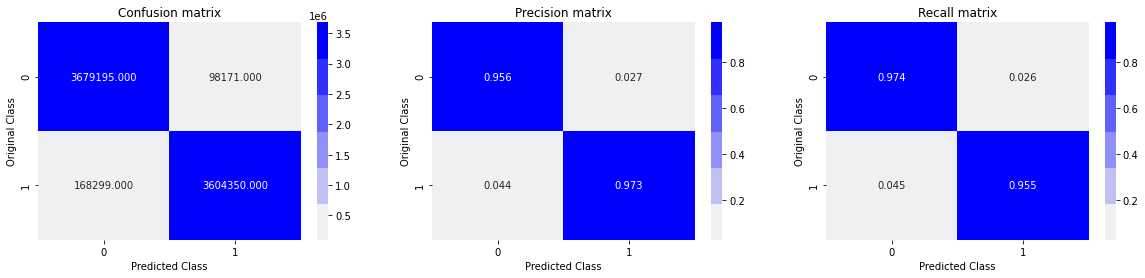

Test confusion_matrix


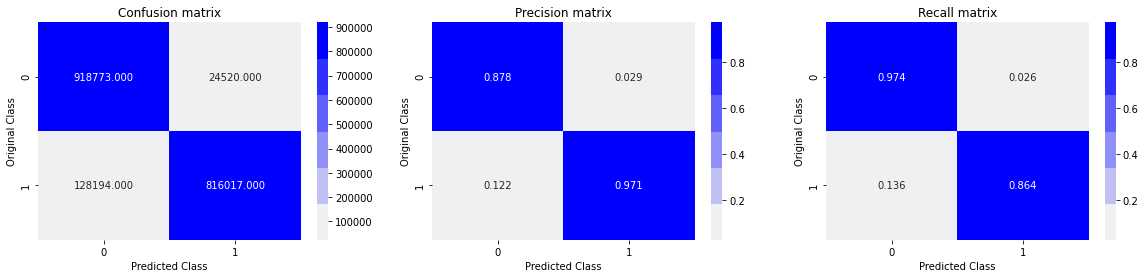

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

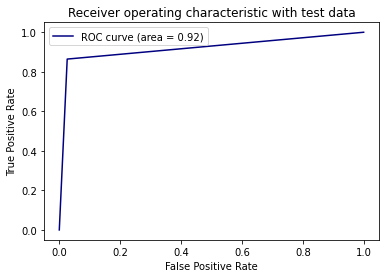

In [ ]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

1. The above analysis we have created around 56 features for analysis from only 2 columns.
2. On Running randon forest for getting the features importance we can see by taking only 20 features listed above we can get more the 99% of important feature.
3. For training the main model which is Xgboost only 50% of the rows are used due to computation constrain with 20 features.
4. The Xgboost is performing pretty good but the is overfitting which may be beacuse of using less no of points.
5. We got a ROC of 0.92 and f1 score of 0.91
6. We can also see in feature importance that a simple follow back feature is the most important among all of them.